Ersteller: Till Fetzer (Wahlfach), Bastian Frewert (1641654, Wahlfach)
Dozent/-in: Prof. Dr. Monika Kochanowski

In [1]:
#Imports

#Allgemein
import pandas as pd
import seaborn  as sb
import sklearn
import math

#Regressoren
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#Classifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Bewertungsmetriken
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix

#Text to numbers
import nltk
import numpy as np

#Modelle speichern und laden
from joblib import dump, load

#Visulalisierung Decision Tree
import matplotlib.pyplot as plt

# Methoden zum Anwenden von Modellen und Bewerten

In [2]:
def doEverythingRegression(filename):
    regressionModel, classificationModel = importModels("trainedModels.joblib")
    classificationData = readData(filename)
    return applyRegressor(regressionModel, classificationData)

def doEverythingClassification(filename):
    regressionModel, classificationModel = importModels("trainedModels.joblib")
    regressionData = readData(filename)
    return applyClassifier(classificationModel, regressionData)
    

def readData(filename):
    if str(filename):
        dataFrame = pd.read_csv(filename, sep= ";")
        return dataFrame;
    
def prepareDataRegression(dataFrame):
    if type(dataFrame) == pd.core.frame.DataFrame:
        #Data Preparation
        #Spalten entfernen
        if "YrSold" in dataFrame.columns:
            dataFrame = dataFrame.drop("YrSold", axis=1)
        #Dies wird entfernt wei lman oben herruasgefunden hat das es mit nichts correliert
        # es also keine auswirkung auf irgendwas hat. und es auch nur 4 verschiedene Werte sind. 
        if "TotRmsAbvGrd" in dataFrame.columns:
            dataFrame = dataFrame.drop("TotRmsAbvGrd", axis=1)
        #Dies wird entfernt,
        #weil es eine sehr starke mit LIvArea zu sammenhängt man also die gleiche Information in zwei Features hat.
        
        
        #One hot encoding
        stringLabels = ["MSZoning","Neighborhood","BldgType","RoofStyle","HeatingQC","CentralAir"]
        for element in stringLabels:
            dataFrame.loc[:,element] = text_to_numbers(dataFrame.loc[:,element])
            
        return dataFrame
    
def splitDataRegression(dataFrame):
    if type(dataFrame) == pd.core.frame.DataFrame:
        #Data Splitting in Data und Sale Price
        x = dataFrame.drop('SalePrice', axis=1)
        y = dataFrame.SalePrice
        return x,y
            
def applyRegressor(model, dataFrame):
    if type(dataFrame) == pd.core.frame.DataFrame:
        dataFrame = prepareDataRegression(dataFrame)
        x,y = splitDataRegression(dataFrame)
        
        if isinstance(model, sklearn.linear_model.base.LinearRegression) :
            #nutzen von nur 3 Features bei der Linearen Regression.
            #hier eventuell bei Fehler _base oder base schreiben!!!!!
            x = x.iloc[:, [4 ,9, 12]]


        #Führe Prediction durch und berechne Messwerte
        pred = model.predict(x)
        r2 = r2_score(y,pred)
        mse = mean_squared_error(y, pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y - pred) / y)) * 100
        maxDiff = np.amax(np.subtract(y,pred))
        
        return {"r2":r2,"mse": mse,"rmse":rmse,"mape":mape,"maxDiff": maxDiff}
        
def splitDataClassification(dataFrame):
    if type(dataFrame) == pd.core.frame.DataFrame:
        x = dataFrame.drop("CentralAir",axis = 1)
        y = dataFrame["CentralAir"]
        return x,y

def applyClassifier(model, dataFrame):
    if type(dataFrame) == pd.core.frame.DataFrame:
        dataFrame = prepareDataRegression(dataFrame)
        x, y = splitDataClassification(dataFrame)
        #Führe Prediction durch und berechne Messwerte
        prediction = model.predict(x)
        dataFrameSize = len(x.index)
        confMat = confusion_matrix(y,prediction).flatten()
        truePositive,falseNegative,falsePositive,trueNegative = np.array(confMat,dtype='f')

        
        if (trueNegative + falsePositive) > 0:
            falsePositiveRate = falsePositive/(trueNegative + falsePositive)
        else:
            falsePositiveRate = 0
        if (truePositive + falseNegative) > 0:
            falseNegativeRate = falseNegative/(truePositive + falseNegative)
        else:
            falseNegativeRate = 0
    
        accuracy = (trueNegative + truePositive) / len(dataFrame)
        
        return {"accuracy": accuracy, "falsePositiveRate": falsePositiveRate, "falseNegativeRate": falseNegativeRate}


def text_to_numbers(text, cutoff_for_rare_words = 1):
    """Function to convert text to numbers. Text must be tokenzied so that
    test is presented as a list of words. The index number for a word
    is based on its frequency (words occuring more often have a lower index).
    If a word does not occur as many times as cutoff_for_rare_words,
    then it is given a word index of zero. All rare words will be zero.
    """
    
    # Flatten list if sublists are present
    if len(text) > 1:
        flat_text = [sublist for sublist in text]
        
    else:
        flat_text = text
    
    # get word freuqncy
    fdist = nltk.FreqDist(flat_text)

    # Convert to Pandas dataframe
    df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
    df_fdist.columns = ['Frequency']

    # Sort by word frequency
    df_fdist.sort_values(by=['Frequency'], ascending=False, inplace=True)

    # Add word index
    number_of_words = df_fdist.shape[0]
    df_fdist['word_index'] = list(np.arange(number_of_words)+1)

   
    
    # Convert pandas to dictionary
    word_dict = df_fdist['word_index'].to_dict()
   
    
    # Use dictionary to convert words in text to numbers
    text_numbers = []
    for string in text:
        string_numbers = word_dict[string]
        text_numbers.append(string_numbers)  
    
    return (text_numbers)
        
        
def exportModels(filename, regressionModel, classificationModel):
    dump([regressionModel, classificationModel], filename)
    
def importModels(filename):
    return load(filename)

In [3]:
doEverythingRegression("SetFiltered.csv")

{'r2': 0.9730793130103527,
 'mse': 137136032.5170478,
 'rmse': 11710.509490071207,
 'mape': 4.601123987241046,
 'maxDiff': 86444.59270000004}

In [4]:
doEverythingClassification("SetFiltered.csv")

{'accuracy': 0.9877777777777778,
 'falsePositiveRate': 0.10909091,
 'falseNegativeRate': 0.00591716}

# Erste Erkenntnisse first look




In [5]:
data = pd.read_csv("SetFiltered.csv", sep= ";") 
type(data)

pandas.core.frame.DataFrame

In [6]:
data

MSZoning  LotArea Neighborhood BldgType  OverallQual  OverallCond  \
0         RL     9590       Timber     1Fam            7            5   
1         RL    12256      NoRidge     1Fam            8            5   
2         RL    12108      Edwards   Duplex            4            4   
3         RL     7500       Sawyer     1Fam            5            5   
4         RM     6000      OldTown   2fmCon            4            4   
..       ...      ...          ...      ...          ...          ...   
895       RL     8750      CollgCr     1Fam            7            5   
896       RL     8064        NAmes     1Fam            5            7   
897       RL    13005       NWAmes     1Fam            7            7   
898       RL     9375      CollgCr     1Fam            8            5   
899       RL     9135      CollgCr     1Fam            7            5   

     YearBuilt  YearRemodAdd RoofStyle  TotalBsmtSF HeatingQC CentralAir  \
0         2003          2003     Gable          868        Ex          Y   
1         1994          1995     Gable         1463        Ex          Y   
2         1955          1955     Gable         1440        TA          N   
3         1963          1963     Gable         1040        Fa          Y   
4         1953          1953     Gable          936        TA          N   
..         ...           ...       ...          ...       ...        ...   
895       1996          1996     Gable          880        Ex          Y   
896       1949          2006     Gable          672        Ex          Y   
897       1980          1980     Gable          845        TA          Y   
898       2002          2002     Gable         1284        Ex          Y   
899       2002          2003     Gable         1536        Ex          Y   

     GrLivArea  TotRmsAbvGrd  GarageCars  YrSold  SalePrice  
0         1146             6           2    2007     187500  
1         2622             9           2    2010     325000  
2         1440             8           0    2008     118000  
3         1040             5           1    2010     133000  
4          936             4           2    2009      93000  
..         ...           ...         ...     ...        ...  
895       1716             7           2    2009     191000  
896        924             6           2    2007     122900  
897       2353            10           2    2009     260000  
898       2169             7           2    2007     228500  
899       1536             7           2    2008     214000  

[900 rows x 17 columns]

Null gibt es sonst nicht
NAN auch nicht
-1 auch nicht 

In [7]:
data[81:82]


MSZoning  LotArea Neighborhood BldgType  OverallQual  OverallCond  \
81  C (all)     8500       IDOTRR     1Fam            4            4   

    YearBuilt  YearRemodAdd RoofStyle  TotalBsmtSF HeatingQC CentralAir  \
81       1920          1950   Gambrel          649        TA          N   

    GrLivArea  TotRmsAbvGrd  GarageCars  YrSold  SalePrice  
81       1317             6           1    2008      40000

Diese Zeilen ist weil wenn man die csv mit Libre Office öffnet war (all) in einer anderen Spalte wodurch das ganze Datenset verschoben war.
Dies ist nur um sicher zustellen, dass es nicht mehr so ist.

In [8]:
data.describe()

LotArea  OverallQual  OverallCond    YearBuilt  YearRemodAdd  \
count     900.000000   900.000000   900.000000   900.000000    900.000000   
mean    10629.817778     6.014444     5.652222  1969.347778   1984.185556   
std      9947.088936     1.336912     1.151555    29.573049     20.195265   
min      1300.000000     1.000000     1.000000  1872.000000   1950.000000   
25%      7432.250000     5.000000     5.000000  1953.000000   1966.000000   
50%      9475.000000     6.000000     5.000000  1971.000000   1993.000000   
75%     11700.000000     7.000000     6.000000  1998.000000   2002.000000   
max    164660.000000    10.000000     9.000000  2009.000000   2009.000000   

       TotalBsmtSF    GrLivArea  TotRmsAbvGrd  GarageCars       YrSold  \
count   900.000000   900.000000    900.000000  900.000000   900.000000   
mean   1028.166667  1487.441111      6.415556    1.745556  2007.896667   
std     403.019702   504.588271      1.601786    0.715887     1.306010   
min       0.000000   334.000000      2.000000    0.000000  2006.000000   
25%     790.250000  1102.750000      5.000000    1.000000  2007.000000   
50%     968.500000  1443.500000      6.000000    2.000000  2008.000000   
75%    1249.500000  1750.500000      7.000000    2.000000  2009.000000   
max    3206.000000  4316.000000     12.000000    4.000000  2010.000000   

           SalePrice  
count     900.000000  
mean   176184.454444  
std     71412.482393  
min     39300.000000  
25%    130000.000000  
50%    161000.000000  
75%    205000.000000  
max    755000.000000

Lot Area riesiges Maximum kann riesige Auswirkungen haben. </br>
Riesiges Minimum und Maximum </br>




In [9]:
data[data["LotArea"].idxmax():data["LotArea"].idxmax()+1]

MSZoning  LotArea Neighborhood BldgType  OverallQual  OverallCond  \
844       RL   164660       Timber   2fmCon            5            6   

     YearBuilt  YearRemodAdd RoofStyle  TotalBsmtSF HeatingQC CentralAir  \
844       1965          1965     Gable         1499        Ex          Y   

     GrLivArea  TotRmsAbvGrd  GarageCars  YrSold  SalePrice  
844       1786             7           2    2008     228950

In [10]:
data["MSZoning"].unique()

array(['RL', 'RM', 'FV', 'RH', 'C (all)'], dtype=object)

In [11]:
data['MSZoning'].value_counts()

RL         716
RM         145
FV          28
RH          10
C (all)      1
Name: MSZoning, dtype: int64

C (all) ist nur alleine 

In [12]:
data = data.query("MSZoning != 'C (all)'")

Da es nur ein C(all) gibt steckt in C(all) keine Information und es wird gesaubert in Sinne der Daten aufbereitung

In [13]:
data['Neighborhood'].value_counts()

NAmes      150
CollgCr    103
OldTown     71
Edwards     53
Sawyer      52
Gilbert     47
NWAmes      46
BrkSide     41
NridgHt     39
SawyerW     37
Somerst     34
Crawfor     34
Mitchel     33
NoRidge     26
Timber      21
IDOTRR      20
SWISU       18
ClearCr     17
StoneBr     13
MeadowV     12
Blmngtn      9
BrDale       9
Veenker      8
NPkVill      5
Blueste      1
Name: Neighborhood, dtype: int64

Blueste kommt nur einmal vor

In [14]:
data = data.query("Neighborhood != 'Blueste'")


Der Grund warum dies gemacht wird ist,  man kann mit der Information Blueste ncihts anfangen wenn es nur einen Eintrag gibt nichts anfangen

In [15]:
data['BldgType'].value_counts()

1Fam      758
TwnhsE     67
Duplex     29
Twnhs      27
2fmCon     17
Name: BldgType, dtype: int64

Einfamiliehaushalt ist am häufigsten 

In [16]:
data['OverallQual'].value_counts()

5     248
6     243
7     193
8      92
4      77
9      23
3      13
10      6
1       2
2       1
Name: OverallQual, dtype: int64

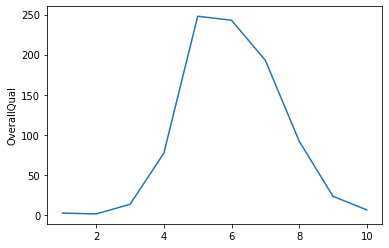

In [17]:
sb.lineplot(data['OverallQual'].value_counts().keys(), data['OverallQual'].value_counts())


schaut nach einer Gaussverteilung aus

In [18]:
data['OverallCond'].value_counts()

5    481
6    157
7    134
8     55
4     40
9     17
3     12
2      1
1      1
Name: OverallCond, dtype: int64

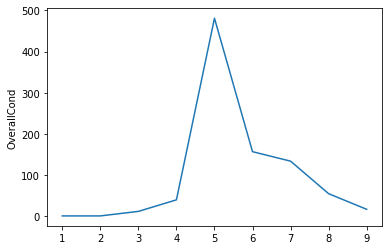

In [19]:
sb.lineplot(data['OverallCond'].value_counts().keys(), data['OverallCond'].value_counts())

In [20]:
data['RoofStyle'].value_counts()

Gable      707
Hip        171
Flat         7
Gambrel      6
Mansard      5
Shed         2
Name: RoofStyle, dtype: int64

Giebel und hip dach sind auf häufigsten 

In [21]:
data['HeatingQC'].value_counts()

Ex    448
TA    262
Gd    161
Fa     26
Po      1
Name: HeatingQC, dtype: int64

schlechte warmequaltität der Heizung ist nur ein Haus

In [22]:
data['CentralAir'].value_counts()

Y    844
N     54
Name: CentralAir, dtype: int64

Meiste haben eine Klimaanlage. 0,93% wichtig um Klassifiakation später zu beurteilen.

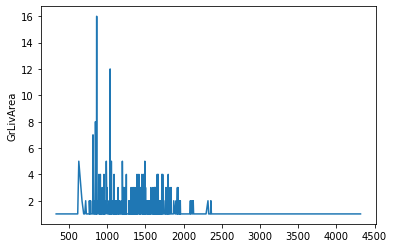

In [23]:
sb.lineplot(data['GrLivArea'].value_counts().keys(), data['GrLivArea'].value_counts())

Viele kleine und der eine ausreisser

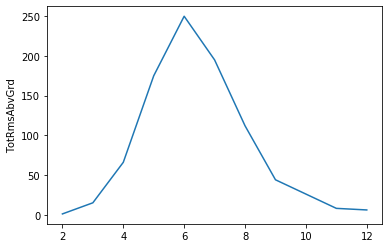

In [24]:
sb.lineplot(data['TotRmsAbvGrd'].value_counts().keys(), data['TotRmsAbvGrd'].value_counts())

Sieht gut aus

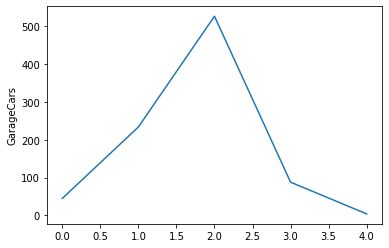

In [25]:
sb.lineplot(data['GarageCars'].value_counts().keys(), data['GarageCars'].value_counts())

geht 

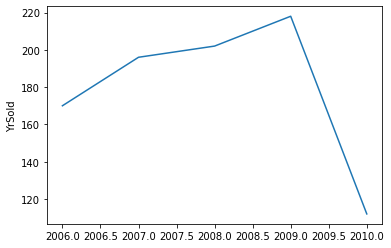

In [26]:
sb.lineplot(data['YrSold'].value_counts().keys(), data['YrSold'].value_counts())

Was war 2009.5 ?

In [27]:
data['YrSold'].value_counts()

2009    218
2008    202
2007    196
2006    170
2010    112
Name: YrSold, dtype: int64

Dieser Datensatz ist in nur 4 Jahren

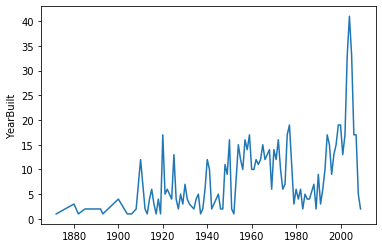

In [28]:
sb.lineplot(data['YearBuilt'].value_counts().keys(), data['YearBuilt'].value_counts())

In [29]:
YearBuilt = data['YearBuilt'].value_counts()

In [30]:
data['YearRemodAdd'].value_counts()

1950    111
2005     53
2004     46
2006     38
2000     37
2002     36
2003     35
2007     32
1996     26
1995     25
1997     23
1998     23
1999     20
1994     16
2001     15
1976     15
2008     14
1972     14
1993     13
1970     13
1977     13
1966     12
1959     12
1990     12
1978     11
1965     11
1968     11
1967     11
1973     10
1971     10
1964      9
1962      9
1991      9
1963      8
1980      8
1975      8
1985      8
1988      8
1957      7
1960      7
1992      7
1954      7
1956      7
1987      7
1981      7
1955      7
1958      7
1969      6
1989      6
1982      6
1953      6
2009      4
1961      4
1979      4
1983      3
1984      3
1986      3
1974      2
1951      2
1952      1
Name: YearRemodAdd, dtype: int64

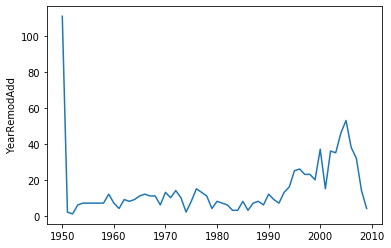

In [31]:
sb.lineplot(data['YearRemodAdd'].value_counts().keys(), data['YearRemodAdd'].value_counts())

1950 gab es eine große renoirierungswelle

In [32]:
data.corr()

LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
LotArea       1.000000     0.078118     0.008611  -0.002769      0.013309   
OverallQual   0.078118     1.000000    -0.070117   0.505580      0.497455   
OverallCond   0.008611    -0.070117     1.000000  -0.413357      0.106004   
YearBuilt    -0.002769     0.505580    -0.413357   1.000000      0.531105   
YearRemodAdd  0.013309     0.497455     0.106004   0.531105      1.000000   
TotalBsmtSF   0.214496     0.503372    -0.179958   0.375120      0.249978   
GrLivArea     0.241608     0.579505    -0.064906   0.150368      0.234302   
TotRmsAbvGrd  0.170915     0.420298    -0.042361   0.058768      0.143257   
GarageCars    0.175377     0.570377    -0.175688   0.502403      0.384041   
YrSold       -0.028536     0.015041    -0.013004   0.042530      0.066916   
SalePrice     0.294612     0.778689    -0.048636   0.471721      0.463600   

              TotalBsmtSF  GrLivArea  TotRmsAbvGrd  GarageCars    YrSold  \
LotArea          0.214496   0.241608      0.170915    0.175377 -0.028536   
OverallQual      0.503372   0.579505      0.420298    0.570377  0.015041   
OverallCond     -0.179958  -0.064906     -0.042361   -0.175688 -0.013004   
YearBuilt        0.375120   0.150368      0.058768    0.502403  0.042530   
YearRemodAdd     0.249978   0.234302      0.143257    0.384041  0.066916   
TotalBsmtSF      1.000000   0.391654      0.255091    0.408928  0.049185   
GrLivArea        0.391654   1.000000      0.835124    0.476622 -0.013700   
TotRmsAbvGrd     0.255091   0.835124      1.000000    0.357591 -0.016895   
GarageCars       0.408928   0.476622      0.357591    1.000000  0.009687   
YrSold           0.049185  -0.013700     -0.016895    0.009687  1.000000   
SalePrice        0.628727   0.758611      0.550466    0.633621  0.010421   

              SalePrice  
LotArea        0.294612  
OverallQual    0.778689  
OverallCond   -0.048636  
YearBuilt      0.471721  
YearRemodAdd   0.463600  
TotalBsmtSF    0.628727  
GrLivArea      0.758611  
TotRmsAbvGrd   0.550466  
GarageCars     0.633621  
YrSold         0.010421  
SalePrice      1.000000

Starke corr zwischen preis mit Qulität, TotalMsmtSF, LivArea, größe Garage. außerdem livArea und room above ground, Idee: eines weglassen  

In [33]:
dataP = data.drop(columns = ["TotRmsAbvGrd"])


In [34]:
dataP = dataP.drop(columns = ["YrSold"])

Hat corr kaum relation mit SalePrice und auch mit den anderen keine, dassheißt hier gibt es keinen Mehrwert 

Weil Daten doppelt mit livArea 

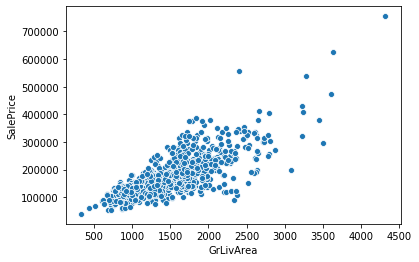

In [35]:
sb.scatterplot(dataP["GrLivArea"],dataP["SalePrice"])

Dadurch passen Ausreißer von Größe und Preis zusammen

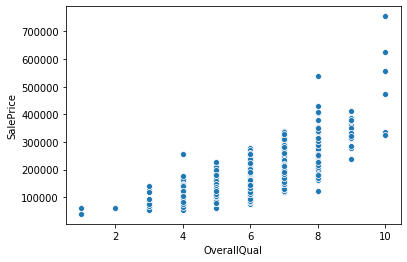

In [36]:
sb.scatterplot(dataP["OverallQual"],dataP["SalePrice"])

qualitat hat range

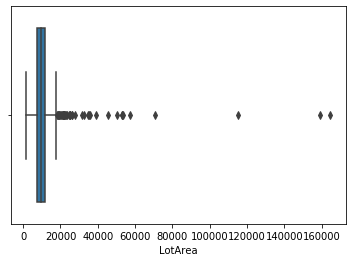

In [37]:
sb.boxplot(dataP["LotArea"])

viele Ausreißer nach oben

In [38]:
dataP = dataP.sample(frac=1, random_state = 42)
#Die Daten zufällig anordnen, random state damit Beispielrechnung richtig und Ergebnisse gleich bleiben

In [39]:
labels = dataP["SalePrice"]
labels

332    117000
639    360000
327    130500
850    185850
39     337500
        ...  
107     80000
271    179500
862    188700
436    213000
103     60000
Name: SalePrice, Length: 898, dtype: int64

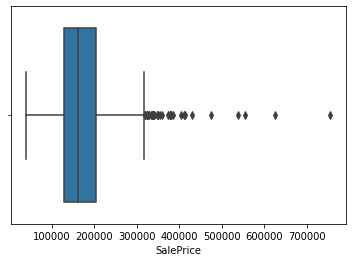

In [40]:
sb.boxplot(dataP["SalePrice"])

In [41]:
lenDataSet = len(dataP)

In [42]:
dataP.loc[:,"MSZoning"]

332    RL
639    RL
327    RL
850    RL
39     RL
       ..
107    RM
271    RL
862    RL
436    RL
103    RL
Name: MSZoning, Length: 898, dtype: object

In [43]:
stringLabels = ["MSZoning","Neighborhood","BldgType","RoofStyle","HeatingQC","CentralAir"]

In [44]:
for element in stringLabels:
    dataP.loc[:,element] = text_to_numbers(dataP.loc[:,element])
data

MSZoning  LotArea Neighborhood BldgType  OverallQual  OverallCond  \
0         RL     9590       Timber     1Fam            7            5   
1         RL    12256      NoRidge     1Fam            8            5   
2         RL    12108      Edwards   Duplex            4            4   
3         RL     7500       Sawyer     1Fam            5            5   
4         RM     6000      OldTown   2fmCon            4            4   
..       ...      ...          ...      ...          ...          ...   
895       RL     8750      CollgCr     1Fam            7            5   
896       RL     8064        NAmes     1Fam            5            7   
897       RL    13005       NWAmes     1Fam            7            7   
898       RL     9375      CollgCr     1Fam            8            5   
899       RL     9135      CollgCr     1Fam            7            5   

     YearBuilt  YearRemodAdd RoofStyle  TotalBsmtSF HeatingQC CentralAir  \
0         2003          2003     Gable          868        Ex          Y   
1         1994          1995     Gable         1463        Ex          Y   
2         1955          1955     Gable         1440        TA          N   
3         1963          1963     Gable         1040        Fa          Y   
4         1953          1953     Gable          936        TA          N   
..         ...           ...       ...          ...       ...        ...   
895       1996          1996     Gable          880        Ex          Y   
896       1949          2006     Gable          672        Ex          Y   
897       1980          1980     Gable          845        TA          Y   
898       2002          2002     Gable         1284        Ex          Y   
899       2002          2003     Gable         1536        Ex          Y   

     GrLivArea  TotRmsAbvGrd  GarageCars  YrSold  SalePrice  
0         1146             6           2    2007     187500  
1         2622             9           2    2010     325000  
2         1440             8           0    2008     118000  
3         1040             5           1    2010     133000  
4          936             4           2    2009      93000  
..         ...           ...         ...     ...        ...  
895       1716             7           2    2009     191000  
896        924             6           2    2007     122900  
897       2353            10           2    2009     260000  
898       2169             7           2    2007     228500  
899       1536             7           2    2008     214000  

[898 rows x 17 columns]

In [45]:
rawdata = dataP.loc[:,"MSZoning":"GarageCars"]
rawdata

MSZoning  LotArea  Neighborhood  BldgType  OverallQual  OverallCond  \
332         1    10998             4         1            5            5   
639         1    12378             9         1            9            5   
327         1     6600            13         1            5            9   
850         1     7052             9         2            7            5   
39          1    12456             9         1           10            5   
..        ...      ...           ...       ...          ...          ...   
107         2     4608             3         1            4            6   
271         1     8400            17         1            5            8   
862         1    11988            11         1            6            7   
436         1     8400             2         1            7            5   
103         1     8400            17         1            2            5   

     YearBuilt  YearRemodAdd  RoofStyle  TotalBsmtSF  HeatingQC  CentralAir  \
332       1941          1960          1          984          1           1   
639       2003          2004          1         1896          1           1   
327       1982          2008          1          816          1           1   
850       2005          2005          1         1364          1           1   
39        2006          2007          2         1700          1           1   
..         ...           ...        ...          ...        ...         ...   
107       1945          1950          1          747          2           1   
271       1939          1997          1          720          1           1   
862       1934          1995          2          715          4           1   
436       2004          2005          1         1473          1           1   
103       1920          1950          1          290          2           2   

     GrLivArea  GarageCars  
332       1604           2  
639       1944           3  
327        816           1  
850       1364           2  
39        1718           3  
..         ...         ...  
107        747           1  
271       2192           1  
862       1660           1  
436       1484           2  
103        438           1  

[898 rows x 14 columns]

In [46]:
trainData = rawdata[0:math.floor(lenDataSet*0.8)]

In [47]:
validateData = rawdata[math.ceil(lenDataSet*0.8):math.floor(lenDataSet*0.95)] 

In [48]:
testData = rawdata[math.ceil(lenDataSet*0.95):]

In [49]:
trainLabels = labels[0:math.floor(lenDataSet*0.8)] 

In [50]:
validateLabels = labels[math.ceil(lenDataSet*0.8):math.floor(lenDataSet*0.95)]

In [51]:
testLabels = labels[math.ceil(lenDataSet*0.95):]

Es ist bewusst das es auch vorgefertigte Methoden zum splitten gibt. Es wurde sich für diese Methode enschieden, weil diese für uns einfacher zu lesen war

# Aufgabenteil 2 - Vorhersage SalePrice

## Random Forest Regressor

In [52]:


rfR = RandomForestRegressor(n_estimators = 1000, random_state = 42, max_features = 3)
rfR.fit(trainData, trainLabels)
#n_estimators = Anzahl an trees 
#random_state = 
# max_featurs = anzahl der feautres maximal 


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=3, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [53]:
rfR.score(validateData, validateLabels)


0.9174617531675052

In [54]:
rfK = RandomForestRegressor(n_estimators = 1000, random_state = 42, max_features = 3)
scores = cross_val_score(rfK, trainData, trainLabels, cv=5)
scores

array([0.88123051, 0.83794313, 0.90861283, 0.89474147, 0.82423702])

In [55]:
rfK = RandomForestRegressor(n_estimators = 1000, random_state = 42, max_features = "sqrt")
scores = cross_val_score(rfK, trainData, trainLabels, cv=5)
scores

array([0.88123051, 0.83794313, 0.90861283, 0.89474147, 0.82423702])

## Gradient Boosting Regressor

In [56]:
gbR = GradientBoostingRegressor(
    max_depth=1,
    n_estimators=1000,
    learning_rate=0.1
)
gbR.fit(trainData, trainLabels)
gbR.score(validateData, validateLabels)
#gbr.predict(rawdata[1:2])

0.9153429326900189

In [57]:
linearData = trainData.iloc[:, [4 ,9, 12]]


## Lineare Regression

In [58]:
clf = LinearRegression().fit(linearData, trainLabels)
#clf.coef_
#clf.intercept_
#clf.score


In [59]:
linearDataV = validateData.iloc[:, [4 ,9, 12]]
clf.score(linearDataV,validateLabels)

0.8522736694312071

In [60]:
clf.coef_

array([21778.7995944 ,    47.55354281,    59.93549851])

In [61]:
clf.intercept_

-93010.30612691233

In [62]:
data[1:4] #vvlt lieber dataP also data Prepared nehmen (weniger Spalten)

MSZoning  LotArea Neighborhood BldgType  OverallQual  OverallCond  \
1       RL    12256      NoRidge     1Fam            8            5   
2       RL    12108      Edwards   Duplex            4            4   
3       RL     7500       Sawyer     1Fam            5            5   

   YearBuilt  YearRemodAdd RoofStyle  TotalBsmtSF HeatingQC CentralAir  \
1       1994          1995     Gable         1463        Ex          Y   
2       1955          1955     Gable         1440        TA          N   
3       1963          1963     Gable         1040        Fa          Y   

   GrLivArea  TotRmsAbvGrd  GarageCars  YrSold  SalePrice  
1       2622             9           2    2010     325000  
2       1440             8           0    2008     118000  
3       1040             5           1    2010     133000

SalePrice =  45.01412324 * OverallQual + 45.01412324 * TotalBsmtSF +  59.93549851 * GrLIvArea -93010.30612691233 
SalePrice =  21778.7995944 * 8 + 45.01412324 * 1463 +   59.93549851 * 2622 - 93010.30612691233 (1)
predicted SalePrice =  307941.8008510381
actuelle SalePrice =  325000
p(Abweichung) =  1 -307941.8008510381/325000 = 0.05248676661219054


SalePrice =  21778.7995944 * 4 + 45.01412324 * 1440 +   59.93549851 * 1440 - 93010.30612691233 (2)
predicted SalePrice =  148889.11174950577
actuelle SalePrice =  118000
p(Abweichung) =  118000/148889.11174950577 = 0.261772133470388

SalePrice =  21778.7995944 * 5 + 45.01412324 * 1040 +   59.93549851 * 1040 - 93010.30612691233 (2)
predicted SalePrice =  127672.29481644908
actuelle SalePrice =  133000
p(Abweichung) =  1 -127672.29481644908/133000 = 0.040057933710909155






In [63]:
1 - 127672.29481644908/133000 

0.040057933710909155

In [64]:
clf.predict(data.iloc[1:2, [4 ,9, 12]])

array([307941.80085104])

# Aufgabenteil 3 - Vorhersage ob es eine Klimananlage gibt (Central Air)


## Kurze Preparation

In [65]:
caData = dataP.loc[:, dataP.columns != 'CentralAir']
caData

MSZoning  LotArea  Neighborhood  BldgType  OverallQual  OverallCond  \
332         1    10998             4         1            5            5   
639         1    12378             9         1            9            5   
327         1     6600            13         1            5            9   
850         1     7052             9         2            7            5   
39          1    12456             9         1           10            5   
..        ...      ...           ...       ...          ...          ...   
107         2     4608             3         1            4            6   
271         1     8400            17         1            5            8   
862         1    11988            11         1            6            7   
436         1     8400             2         1            7            5   
103         1     8400            17         1            2            5   

     YearBuilt  YearRemodAdd  RoofStyle  TotalBsmtSF  HeatingQC  GrLivArea  \
332       1941          1960          1          984          1       1604   
639       2003          2004          1         1896          1       1944   
327       1982          2008          1          816          1        816   
850       2005          2005          1         1364          1       1364   
39        2006          2007          2         1700          1       1718   
..         ...           ...        ...          ...        ...        ...   
107       1945          1950          1          747          2        747   
271       1939          1997          1          720          1       2192   
862       1934          1995          2          715          4       1660   
436       2004          2005          1         1473          1       1484   
103       1920          1950          1          290          2        438   

     GarageCars  SalePrice  
332           2     117000  
639           3     360000  
327           1     130500  
850           2     185850  
39            3     337500  
..          ...        ...  
107           1      80000  
271           1     179500  
862           1     188700  
436           2     213000  
103           1      60000  

[898 rows x 14 columns]

In [66]:
caLabels = dataP["CentralAir"]
caLabels

332    1
639    1
327    1
850    1
39     1
      ..
107    1
271    1
862    1
436    1
103    2
Name: CentralAir, Length: 898, dtype: int64

In [67]:
trainCaData = caData[0:math.floor(lenDataSet*0.8)]

In [68]:
validateCaData = caData[math.ceil(lenDataSet*0.8):math.floor(lenDataSet*0.95)] 

In [69]:
testCaData = caData[math.ceil(lenDataSet*0.95):]

In [70]:
trainCaLabels = caLabels[0:math.floor(lenDataSet*0.8)] 

In [71]:
validateCaLabels = caLabels[math.ceil(lenDataSet*0.8):math.floor(lenDataSet*0.95)]

In [72]:
testCaLabels = caLabels[math.ceil(lenDataSet*0.95):]

## Decision Tree Classifier

In [73]:
dtC= tree.DecisionTreeClassifier()
dtC = dtC.fit(trainCaData, trainCaLabels)
dtC.score(validateCaData,validateCaLabels)


0.9328358208955224

## Random Forest Classifier

In [74]:
rfC = RandomForestClassifier(max_depth=2, random_state=0)
rfC.fit(trainCaData, trainCaLabels)
rfC.score(validateCaData, validateCaLabels)

C:\Users\meton\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9328358208955224

## Gradient Boosting Classifier

In [75]:
gbC = GradientBoostingClassifier(n_estimators=20, max_features=2, max_depth=2, random_state=0)
gbC.fit(trainCaData, trainCaLabels)
gbC.score(validateCaData, validateCaLabels)

0.9402985074626866

93% der Häuser haben eine Klimaanlage. Beachten!!!

In [76]:
rg = []
testdata = data[math.ceil(lenDataSet*0.8):]

In [77]:
#Linear Regression
rg.append(applyRegressor(clf,testdata))


In [78]:
#Gradient Boosting Tree Regression
rg.append(applyRegressor(gbR,testdata))

In [79]:
#Random Forest Regression
rg.append(applyRegressor(rfR,testdata))

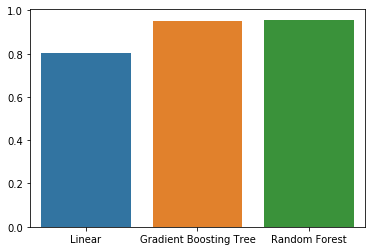

In [80]:
r2=[]
mse=[]
rmse = []
mape=[]
maxD=[]
for i in rg:
    r2.append(i["r2"])
    mse.append(i["mse"])
    rmse.append(i["rmse"])
    mape.append(i["mape"])
    maxD.append(i["maxDiff"])
#r2
sb.barplot(["Linear","Gradient Boosting Tree","Random Forest"],r2)


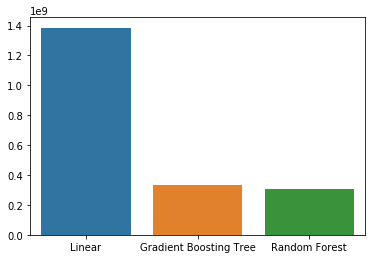

In [81]:
sb.barplot(["Linear","Gradient Boosting Tree","Random Forest"],mse)

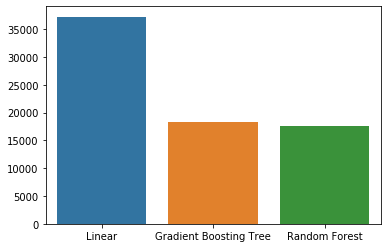

In [82]:
sb.barplot(["Linear","Gradient Boosting Tree","Random Forest"],rmse)

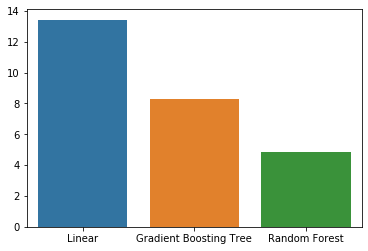

In [83]:
sb.barplot(["Linear","Gradient Boosting Tree","Random Forest"],mape)

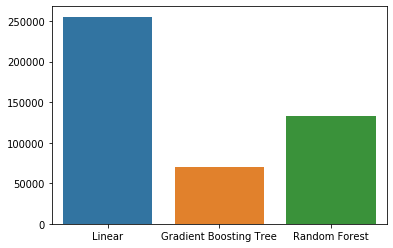

In [84]:
sb.barplot(["Linear","Gradient Boosting Tree","Random Forest"],maxD)

Wie erwartet ist der Lineare Regressor der mit Abstand schlechteste Regressor unserer Modelle, da es sich nur auf 3 Werte aus den gegebenen Werten bezieht und es vom Aufbau mit das leichteste ist.

Gradient Boosting Tree Regressor und Random Forest Regressor unterscheiden sich in den Messwerten R^2, MSE und RMSE relativ wenig.
Sie unterscheiden sich in der maximalen Differenz und dem MAPE Wert. Wir bevorzugen den MAPE Wert, weil die Maximale Differenz wenig aussagt, da sie durch einen Ausreißer stark verändert werden kann.
Da aber Random Forest einen besseren MAPE Wert besitzt werden wir dieses Modell weiter optimieren.

In [85]:
cl = []

In [86]:
#Decision Tree Classifier
cl.append(applyClassifier(dtC, testdata))


In [87]:
#Random Forest Classifier
cl.append(applyClassifier(rfC, testdata))

In [88]:
#Gradient Boosting Tree Classifier
cl.append(applyClassifier(gbC, testdata))

{'accuracy': 0.994413407821229, 'falsePositiveRate': 0.125, 'falseNegativeRate': 0.0}
{'accuracy': 0.9553072625698324, 'falsePositiveRate': 1.0, 'falseNegativeRate': 0.0}
{'accuracy': 0.9664804469273743, 'falsePositiveRate': 0.75, 'falseNegativeRate': 0.0}


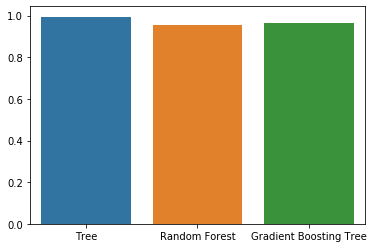

In [89]:
#{"accuracy": accuracy, "falsePositiveRate": falsePositiveRate, "falseNegativeRate": falseNegativeRate}
accuracy= []
falsePositiveRate =[]
falseNegativeRate = []

for i in cl:
    print(i)
    accuracy.append(i["accuracy"])
    falsePositiveRate.append(i["falsePositiveRate"])
    falseNegativeRate.append(i["falseNegativeRate"])
    
#r2
sb.barplot(["Tree","Random Forest","Gradient Boosting Tree"],accuracy)

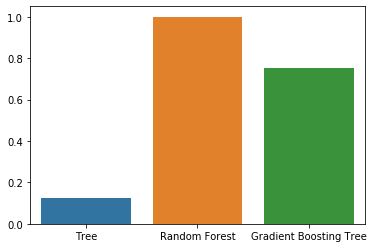

In [90]:
sb.barplot(["Tree","Random Forest","Gradient Boosting Tree"],falsePositiveRate)

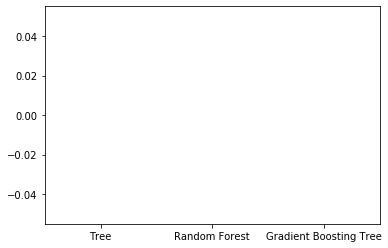

In [91]:
sb.barplot(["Tree","Random Forest","Gradient Boosting Tree"],falseNegativeRate)

Der Entscheidungsbaum hat wie man sieht die höchste Accuracy und eine gegenüber den anderen Modellen kleinere false Positive Rate.

Was auffällt: Bei allen Classifieren liegt die false Negative Rate bei 0.

Aufgrund der höheren Accuracy und den allgemein besseren Werten entscheiden wir uns dafür den Entscheidungsbaum zu optimieren und später einzusetzen.


# Optimierung der Modelle

## Optimierung Random Forest Regressor

In [92]:
#Alt:
applyRegressor(rfR,testdata)

{'r2': 0.9560993529271428,
 'mse': 307851582.9420675,
 'rmse': 17545.699841900507,
 'mape': 4.865994812443826,
 'maxDiff': 132639.17599999998}

In [93]:
#rfR2 = RandomForestRegressor(n_estimators = 100000, random_state = 42, max_features = 3)
#rfR2.fit(trainData, trainLabels)
#applyRegressor(rfR2,testdata)

Eine höhere Anzahl an Estimators bringt eine höhere Performance in den Messwerten, doch das Berechnen wird immer langsamer sodass wir den Wert für die Tests nicht weiter erhöhen werden als 10000.
Die Performance der Messwerte scheint sich einem Grenzwert anzunähern.

In [94]:
rfR3 = RandomForestRegressor(n_estimators = 10000, random_state = 42, max_features = 3)
rfR3.fit(trainData, trainLabels)
applyRegressor(rfR3,testdata)

{'r2': 0.9596921006232065,
 'mse': 282657579.22933996,
 'rmse': 16812.42335980569,
 'mape': 4.860086231216309,
 'maxDiff': 122596.54929999996}

In [95]:
rfR3 = RandomForestRegressor(n_estimators = 10000, random_state = 42, max_features = 4)
rfR3.fit(trainData, trainLabels)
applyRegressor(rfR3,testdata)

{'r2': 0.9638271582018716,
 'mse': 253660648.5226929,
 'rmse': 15926.727489434008,
 'mape': 4.782334863470758,
 'maxDiff': 110640.13919999998}

In [96]:
rfR4 = RandomForestRegressor(n_estimators = 10000, random_state = 42, max_features = 10)
rfR4.fit(trainData, trainLabels)
applyRegressor(rfR4,testdata)

{'r2': 0.9668657449184039,
 'mse': 232352677.1609313,
 'rmse': 15243.119010259392,
 'mape': 4.876909028725267,
 'maxDiff': 91858.71299999999}

In [97]:
rfR5 = RandomForestRegressor(n_estimators = 10000, random_state = 42, max_features = 7)
rfR5.fit(trainData, trainLabels)
applyRegressor(rfR5,testdata)

{'r2': 0.9666794652310243,
 'mse': 233658956.23546538,
 'rmse': 15285.907111959872,
 'mape': 4.779284998759749,
 'maxDiff': 97630.89820000005}

In [98]:
rfR6 = RandomForestRegressor(n_estimators = 10000, random_state = 42, max_features = 6)
rfR6.fit(trainData, trainLabels)
applyRegressor(rfR6,testdata)

{'r2': 0.9662487872371085,
 'mse': 236679068.94463012,
 'rmse': 15384.37743116796,
 'mape': 4.760277303939834,
 'maxDiff': 100803.7352}

In [99]:
rfR7 = RandomForestRegressor(n_estimators = 10000, random_state = 42, max_features = 8)
rfR7.fit(trainData, trainLabels)
applyRegressor(rfR7,testdata)

{'r2': 0.9666710114435733,
 'mse': 233718238.0917064,
 'rmse': 15287.84609065994,
 'mape': 4.835020220092167,
 'maxDiff': 96630.35360000003}

Wir entscheiden uns für einen Baum mit 6 Features, da er einen niedrigen MAPE Wert aufweißt und die anderen Faktoren, dadurch nicht so viel in Mitleidenschaft gezoigen werden, wie bei anderen Random Forests.

In [100]:
rfRFinal = RandomForestRegressor(n_estimators = 10000, random_state = 42, max_features = 6)
rfRFinal.fit(trainData, trainLabels)
applyRegressor(rfRFinal,testdata)

{'r2': 0.9662487872371085,
 'mse': 236679068.94463012,
 'rmse': 15384.37743116796,
 'mape': 4.760277303939834,
 'maxDiff': 100803.7352}

## Optimieren des Decision Treee Classifiers

In [101]:
dtC = tree.DecisionTreeClassifier(criterion="gini", max_depth = None, min_samples_split = 2)
dtC = dtC.fit(trainCaData, trainCaLabels)
applyClassifier(dtC, testdata)

{'accuracy': 0.994413407821229,
 'falsePositiveRate': 0.125,
 'falseNegativeRate': 0.0}

In [102]:
dtC2 = tree.DecisionTreeClassifier(criterion="entropy", max_depth = None, min_samples_split = 2)
dtC2.fit(trainCaData, trainCaLabels)
applyClassifier(dtC2, testdata)

{'accuracy': 0.994413407821229,
 'falsePositiveRate': 0.125,
 'falseNegativeRate': 0.0}

In [103]:
dtC3 = tree.DecisionTreeClassifier(criterion="entropy", max_depth = 11, min_samples_split = 2)
dtC3.fit(trainCaData, trainCaLabels)
applyClassifier(dtC3, testdata)

{'accuracy': 0.994413407821229,
 'falsePositiveRate': 0.125,
 'falseNegativeRate': 0.0}

In [104]:
dtC4 = tree.DecisionTreeClassifier(criterion="gini", max_depth = 4, min_samples_split = 2)
dtC4.fit(trainCaData, trainCaLabels)
applyClassifier(dtC4, testdata)

{'accuracy': 0.994413407821229,
 'falsePositiveRate': 0.125,
 'falseNegativeRate': 0.0}

Sobald man das Kriterium ändert und ein bisschen mit der Max Tiefe rumspielt, erhält man das Ergebnis, dass das Kriterium Gini anscheinend besser ist als Entropy, da es mit einer geringeren Tiefe von 4 (bei Gini) zu 11 (bie Entropy) die gelcihe Accuracy und Rates bringt.

In [105]:
dtC5 = tree.DecisionTreeClassifier(criterion="gini", max_depth = 4, min_samples_split = 26)
dtC5.fit(trainCaData, trainCaLabels)
applyClassifier(dtC5, testdata)

{'accuracy': 0.9664804469273743,
 'falsePositiveRate': 0.375,
 'falseNegativeRate': 0.01754386}

Die Variation von minimalen Samples bringt keine besseren Ergebnisse als wir nciht sowieso schon haben. Auch andere Variationen brachten keine weiteren Ergebnisse. Draraus folgend werden wir die Voreinstellungen mit Kriterium gleich Gini, einer unbegrenzten mmaximalen Tiefe und Splitten bei 2.

Uns kommt das Ergebnis von einer Accuarcy von 0,96.... eher komisch vor aber wir finden keine Erklärung, deswegen arbeiten wir trotzdem damit weiter.

In [106]:
dtCFinal = tree.DecisionTreeClassifier(criterion="gini", max_depth = None, min_samples_split = 2)
dtCFinal.fit(trainCaData, trainCaLabels)
applyClassifier(dtCFinal, testdata)

{'accuracy': 0.994413407821229,
 'falsePositiveRate': 0.125,
 'falseNegativeRate': 0.0}

In [107]:
exportModels("trainedModels.joblib", rfRFinal, dtCFinal)

# Anwenden der Modelle auf Trainingsdatensatz, Testdatensatz und den gesammten Datensatz

Anmerkung: Die Daten sind die gleichen wie oben verwendet da Reihenfolge immer gleich bleibt. Werden nur hier, wel sie vorher in Data und Labels getrennt wurden neu in Zeilen aufgeteilt.

In [108]:
trainData = data[0:math.floor(lenDataSet*0.8)]

Validation Data wird nicht benötigt.

In [109]:
testData = data[math.ceil(lenDataSet*0.95):]

## Regression

In [110]:
applyRegressor(rfRFinal, trainData)

{'r2': 0.970958383614906,
 'mse': 133094331.79078487,
 'rmse': 11536.651671554657,
 'mape': 4.679743733780902,
 'maxDiff': 65112.36680000002}

In [111]:
applyRegressor(rfRFinal, testData)

{'r2': 0.9622804723307457,
 'mse': 407933384.27035356,
 'rmse': 20197.360824383803,
 'mape': 4.727154104556354,
 'maxDiff': 100866.26839999994}

In [112]:
applyRegressor(rfRFinal, data)

{'r2': 0.9737959749253781,
 'mse': 133160792.83489668,
 'rmse': 11539.53174244504,
 'mape': 4.439607474060039,
 'maxDiff': 86444.59270000004}

## Classification

In [113]:
applyClassifier(dtCFinal, trainData)

{'accuracy': 0.9888579387186629,
 'falsePositiveRate': 0.13043478,
 'falseNegativeRate': 0.0029761905}

In [114]:
#applyClassifier(dtCFinal, testData) Fehler zu wenig sachen in confusionsMatrix

In [115]:
applyClassifier(dtCFinal, data)

{'accuracy': 0.9899777282850779,
 'falsePositiveRate': 0.12962963,
 'falseNegativeRate': 0.0023696683}

# Visualisierung Decision Tree

In [116]:
plt.figure(figsize=(300,300))
abc = tree.plot_tree(dtCFinal,feature_names = trainCaData.columns, filled = True, node_ids = False, fontsize = 150)